# Libraries

In [30]:
import torch
from torchvision import datasets, transforms, models
import os
import shutil
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torchinfo import summary
import matplotlib.pylab as plt

# Default Device

In [31]:
if torch.cuda.is_available(): print(torch.cuda.get_device_name()) 
else: print('cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

NVIDIA GeForce GTX 1660 Ti


# Splitting Train, Valid, Test

In [32]:
# Path to dataset
dataset_dir = 'dataset'
class_0_dir = os.path.join(dataset_dir, '0')
class_1_dir = os.path.join(dataset_dir, '1')

# Get all image file paths and their corresponding labels
class_0_images = glob(os.path.join(class_0_dir, "*"))
class_1_images = glob(os.path.join(class_1_dir, "*"))

# Create labels
class_0_labels = [0] * len(class_0_images)
class_1_labels = [1] * len(class_1_images)

# Combine the data and labels
all_images = class_0_images + class_1_images
all_labels = class_0_labels + class_1_labels

In [33]:
# Split the data into train (70%), and a temporary validation+test set (30%)
train_images, temp_images, train_labels, temp_labels = train_test_split(all_images, all_labels, 
                                                                        test_size=0.3, 
                                                                        stratify=all_labels, 
                                                                        shuffle=True,
                                                                        random_state=42)

# Further split the temporary set into validation (15%) and test (15%)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, 
                                                                    test_size=0.5, 
                                                                    stratify=temp_labels,
                                                                    shuffle=True,
                                                                    random_state=42)

In [34]:
def create_and_move(images, labels, split_name, base_dir):
    """
    Creates directories for the given split and moves image files to their respective class folders.

    Args:
        images (list of str): List of file paths for the images to be moved.
        labels (list of int): List of labels corresponding to each image.
        split_name (str): The name of the split (e.g., 'train', 'val', 'test') which will be used to create directories.
        base_dir (str): Base directory where the split directories will be created.
    """

    split_dir = os.path.join(base_dir, split_name)
    os.makedirs(os.path.join(split_dir, "0"), exist_ok=True)
    os.makedirs(os.path.join(split_dir, "1"), exist_ok=True)
    
    for img, label in tqdm(zip(images, labels), total=len(images), desc=f"Copying {split_name}", leave=False):
        label_dir = os.path.join(split_dir, str(label))
        shutil.copy(img, label_dir)

In [35]:
# Path to the new directory where we want to save the split dataset
new_base_dir = 'splitted_data'
os.makedirs(new_base_dir, exist_ok=True)

In [36]:
# Create the new directories and move the files
create_and_move(train_images, train_labels, "train", new_base_dir)
create_and_move(val_images, val_labels, "val", new_base_dir)
create_and_move(test_images, test_labels, "test", new_base_dir)

# Loading Datasets

In [37]:
transform = transforms.Compose([transforms.Resize((224,224), antialias=True),
                                transforms.ToTensor(),
                                transforms.ConvertImageDtype(torch.float),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

batch_size = 32

In [38]:
# Load the datasets from the folder structure
image_datasets = {'train': datasets.ImageFolder(root=f'{new_base_dir}/train', transform=transform),
                  'val': datasets.ImageFolder(root=f'{new_base_dir}/val', transform=transform),
                  'test':  datasets.ImageFolder(root=f'{new_base_dir}/test', transform=transform)}

# Create DataLoaders for each dataset
dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
               'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True),
               'test':  DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True)}

# Model

In [39]:
Alex = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1).to(device)
Alex.classifier[-1] = nn.Linear(in_features=4096, out_features=2)

In [40]:
for x in Alex.features.parameters(): x.requires_grad = False
summary(Alex, [batch_size, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [32, 2]                   --
├─Sequential: 1-1                        [32, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [32, 64, 55, 55]          (23,296)
│    └─ReLU: 2-2                         [32, 64, 55, 55]          --
│    └─MaxPool2d: 2-3                    [32, 64, 27, 27]          --
│    └─Conv2d: 2-4                       [32, 192, 27, 27]         (307,392)
│    └─ReLU: 2-5                         [32, 192, 27, 27]         --
│    └─MaxPool2d: 2-6                    [32, 192, 13, 13]         --
│    └─Conv2d: 2-7                       [32, 384, 13, 13]         (663,936)
│    └─ReLU: 2-8                         [32, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [32, 256, 13, 13]         (884,992)
│    └─ReLU: 2-10                        [32, 256, 13, 13]         --
│    └─Conv2d: 2-11                      [32, 256, 13, 13]

# Training

In [41]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        # Define cross entropy loss
        self.cross_entropy = nn.CrossEntropyLoss()

    # Override forward method
    def forward(self, outputs, targets):
        # Return the cross entropy loss
        x = self.cross_entropy(outputs, targets)
        return x

In [42]:
epochs = 20
lr = 0.001
criterion = CustomLoss()
optimizer = optim.SGD(Alex.parameters(), lr=lr, momentum=0.9)
save_path = 'net'
os.makedirs(save_path, exist_ok=True)

In [43]:
# Initialize the history dictionary to store training and validation loss/accuracy over epochs
history = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
# Initialize a very large value for the minimum validation loss to track the best model
min_loss = 1e9

# Loop over the specified number of epochs
for ep in range(epochs):

    Alex.train()
    # Get the number of steps/batches in the training dataloader
    steps = len(dataloaders['train'])
    # Initialize accumulators for total loss, accuracy, and number of samples
    total_loss, acc, count = 0, 0, 0

    # Iterate over batches in the training dataloader with tqdm for progress visualization
    for features, labels in tqdm(dataloaders['train'], total=steps, desc=f'Training Epoch {ep+1}', leave=False):
        # Move features and labels to the device (GPU/CPU)
        features, labels = features.to(device), labels.to(device)

        # Zero the gradients before the backpropagation step
        optimizer.zero_grad()

        # Forward pass:
        outputs = Alex(features)
        loss = criterion(outputs, labels)

        # Backward pass:
        loss.backward()

        # Update the model's parameters
        optimizer.step()

        # Loss and Acc
        total_loss+=loss
        predicted_value = torch.argmax(outputs, 1)
        acc+=(predicted_value==labels).sum()
        count+=len(labels)

    # Compute average training loss and accuracy for this epoch
    tl,ta = total_loss.item()/count, acc.item()/count
    history['train_loss'].append(tl)
    history['train_acc'].append(ta)


    Alex.eval()
    # Get the number of steps/batches in the training dataloader
    steps = len(dataloaders['val'])
    # Initialize accumulators for total loss, accuracy, and number of samples
    total_loss, acc, count = 0, 0, 0

    # Iterate over batches in the validation dataloader with tqdm for progress visualization
    for features, labels in tqdm(dataloaders['val'], total=steps, desc=f'Validating Epoch {ep+1}', leave=False):
        # Disable gradient computation during evaluation
        with torch.no_grad():
            # Move features and labels to the device (GPU/CPU)
            features, labels = features.to(device), labels.to(device)

            # Forward pass:
            outputs = Alex(features)
            loss = criterion(outputs, labels)

            # Loss and Acc
            total_loss+=loss
            predicted_value = torch.argmax(outputs, 1)
            acc+=(predicted_value==labels).sum()
            count+=len(labels)

    # Compute average validation loss and accuracy for this epoch
    vl,va = total_loss.item()/count, acc.item()/count
    history['val_loss'].append(vl)
    history['val_acc'].append(va)

    # Check if the current validation loss is the best (smallest) so far and save if so
    if vl <= min_loss:
        torch.save(Alex.state_dict(), os.path.join(save_path, 'alex_weights_min_loss.pth'))
        min_loss = vl
    torch.save(Alex.state_dict(), os.path.join(save_path, 'alex_weights.pth'))

    print(f'Epoch {ep+1:3} / {epochs} :  Train Loss: {tl:.8f}, Valid Loss: {vl:.8f}, Train acc: {ta:.8f}, Valid acc: {va:.8f}')

Training Epoch 1:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch   1 / 20 :  Train Loss: 0.01284234, Valid Loss: 0.00281562, Train acc: 0.80701754, Valid acc: 1.00000000


Epoch   2 / 20 :  Train Loss: 0.00055861, Valid Loss: 0.00079292, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch   3 / 20 :  Train Loss: 0.00030182, Valid Loss: 0.00053425, Train acc: 0.99415205, Valid acc: 1.00000000


Epoch   4 / 20 :  Train Loss: 0.00008153, Valid Loss: 0.00043378, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch   5 / 20 :  Train Loss: 0.00005255, Valid Loss: 0.00039059, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch   6 / 20 :  Train Loss: 0.00002960, Valid Loss: 0.00036776, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch   7 / 20 :  Train Loss: 0.00002036, Valid Loss: 0.00063472, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch   8 / 20 :  Train Loss: 0.00003077, Valid Loss: 0.00039546, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch   9 / 20 :  Train Loss: 0.00001285, Valid Loss: 0.00045453, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch  10 / 20 :  Train Loss: 0.00002093, Valid Loss: 0.00033696, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch  11 / 20 :  Train Loss: 0.00002873, Valid Loss: 0.00060211, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch  12 / 20 :  Train Loss: 0.00001379, Valid Loss: 0.00042360, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch  13 / 20 :  Train Loss: 0.00001748, Valid Loss: 0.00033439, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch  14 / 20 :  Train Loss: 0.00001177, Valid Loss: 0.00033479, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch  15 / 20 :  Train Loss: 0.00001686, Valid Loss: 0.00034474, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch  16 / 20 :  Train Loss: 0.00001215, Valid Loss: 0.00163218, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch  17 / 20 :  Train Loss: 0.00002632, Valid Loss: 0.00050785, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch  18 / 20 :  Train Loss: 0.00001370, Valid Loss: 0.00033804, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch  19 / 20 :  Train Loss: 0.00001730, Valid Loss: 0.00033762, Train acc: 1.00000000, Valid acc: 1.00000000


Epoch  20 / 20 :  Train Loss: 0.00002758, Valid Loss: 0.00055625, Train acc: 1.00000000, Valid acc: 1.00000000


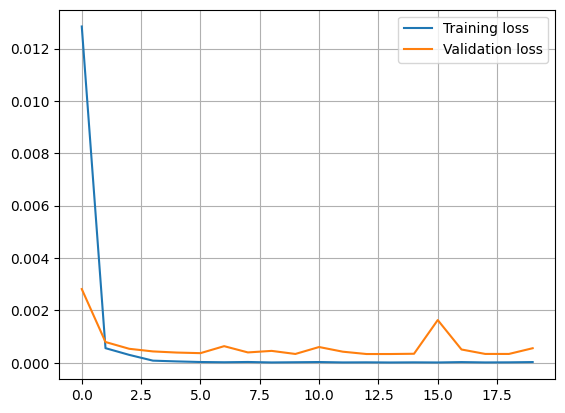

In [44]:
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()
plt.grid()
plt.show()

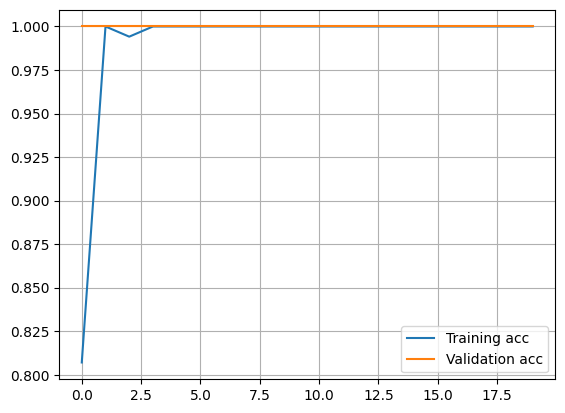

In [45]:
plt.plot(history['train_acc'], label='Training acc')
plt.plot(history['val_acc'], label='Validation acc')
plt.legend()
plt.grid()
plt.show()